<font size = "5"> **Chapter 4:  [Spectroscopy](Ch4-Spectroscopy.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss Spectra
<br>

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>

by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes




## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum


Relavant notebooks in course [MSE 672: Introduction to TEM]()  give an in depth explanation of the method.

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## Prerequesites
This notebook will only run with  ``version 0.2022.6.0`` or higher.

### Install missing packages
This can take a while for the first time. This code will have to run at least once on you computer or colab session.

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.3.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Load the relevant packages

In [1]:
%matplotlib notebook
import numpy as np
%gui qt5
import sys
sys.path.insert(0, '../../')

import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 

import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEMlib version: ', pyTEMlib.__version__)
if pyTEMlib.__version__ < '0.2023.3.0':
    print('This version of pyTEMlib will not work with this notebook')
    print('Please install new pyTEMlib version with code cell above first and then restart this notebook!')
    
__notebook__ = 'analyze_core_loss'
__notebook_version__ = '2023_03_20'

Symmetry functions of spglib enabled
pyTEMlib version:  0.2023.3.0


## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


In [2]:
filename='../../example_data/EELS_STO.dm3'

datasets=  ft.open_file(filename=filename)
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: 01-EELS Acquire_STO',), value='Channel_000: 01-…

<IPython.core.display.Javascript object>


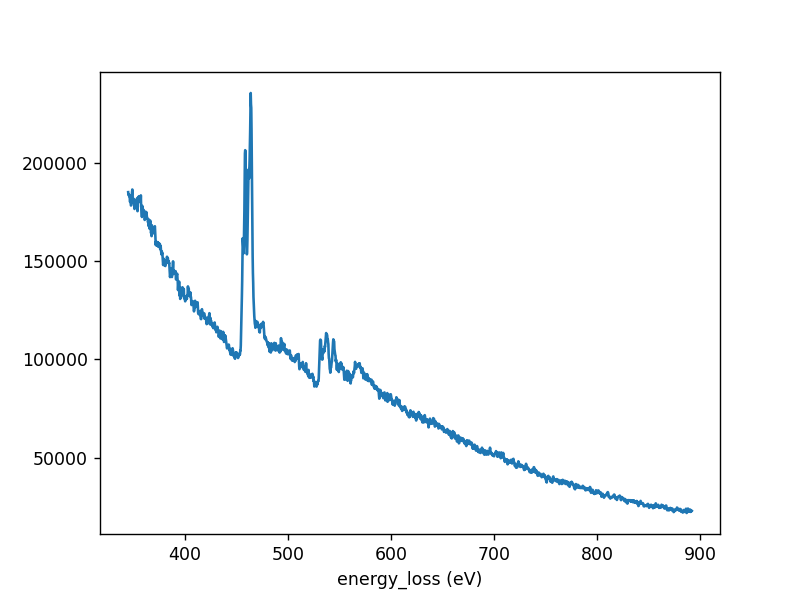

In [5]:
dataset = chooser.dataset
dataset.energy_loss /= eels.get_slope(dataset.energy_loss)/(108/(820-416))
dataset.energy_loss -= dataset.energy_loss[0]-344.8

if dataset.data_type.name in ['SPECTRUM', 'SPECTRAL_IMAGE']:
    info = ieels.InfoDialog(datasets, chooser.key)
else:
    print('We really need a spectrum here')
    dataset.plot()

## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$




In [8]:
print('Auto Quantification')
eels.auto_chemical_composition(dataset)

Auto Quantification

Relative composition: 
O: 80.9%  Ti: 19.1%  


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

<IPython.core.display.Javascript object>


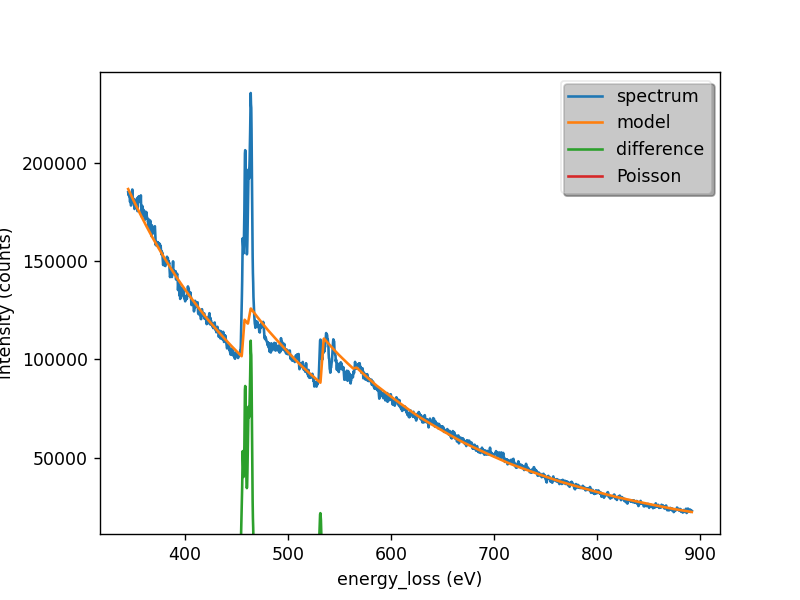

In [10]:
composition = ieels.CompositionDialog(dataset)

### Output of Results

In [10]:
edges = dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])

print('Relative chemical composition of ', dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges

Relative chemical composition of  01_EELS Acquire_STO
Ti: 18.8 %
O: 81.2 %


### Log Data
All the data associated with quantification are stored in the ``metadata`` attribute. The relevant keys of that dictionary are:  ``experiment`` and  ``edges``.

In [ ]:
dataset.metadata.keys()

In [ ]:
dataset.metadata

## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (only 0 iteration available at this time) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).

Please note that the peaks do not necessarily have a physcial meaning as there are peaks with 
positive and negative amplitudes. The goal is to get a smooth representation of the spectrum.
A difference of a good fit and the data should result in a residual of noise only. To achieve such a good fit, the careful setting of the edge onset is important.


In [ ]:
peak_dialog = ieels.PeakFitDialog(dataset)

### Output

In [ ]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

### Log Data
All the data associated with quantification are stored in the ``metadata`` attribute. 
The new key in that dictionary is: ``peak_fit``.

In [18]:
dataset.metadata.keys()

dict_keys(['filename', 'edges', 'experiment'])

## Save and Close File
The dataset with the metadata should be saved for further quantification. 
The file needs to be closed to be used with other notebooks.

In [12]:
h5_group = ft.save_dataset(datasets, '../../example_data/EELS_STO.hf5')
h5_group.file.close()

C:\Users\gduscher\Anaconda3\envs\mse672\lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:01-EELS Acquire_STO to 01_EELS Acquire_STO
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\Anaconda3\envs\mse672\lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
